In [1]:
!pip install -q transformers
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q torch
!pip install -q accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 9.5 MB/s eta 0:00:00


# Imports

In [2]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import set_seed
from peft import LoraConfig, get_peft_model

import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.nn as nn
import bitsandbytes as bnb
import transformers
import peft

# Setting Up Model

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [4]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [5]:
data = []
with open("parsed_quotes_context.txt") as sherlock_quotes_file:
    lines = sherlock_quotes_file.readlines()
    for i in range(0, len(lines), 3):
        if i + 1 < len(lines):
            concatenated_lines = f"{lines[i].strip()} ->: {lines[i+1].strip()}"
            data.append(concatenated_lines)

In [6]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=50)

train_data = [tokenizer(line) for line in train_data]
val_data = [tokenizer(line) for line in val_data]

In [7]:
class CastOutputToFloat(nn.Sequential):
    def forward(self, x): return super().forward(x).to(torch.float32)

In [8]:
hyperparams = [0.025, 0.05, 0.1, 0.2, 0.3]
validation_losses = {x: [] for x in hyperparams} # {hyperparam_value: validation_losses}
training_losses = {x: [] for x in hyperparams} # {hyperparam_value: training_losses}

# Training Model

In [9]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

for hyperparam in hyperparams:
  config = LoraConfig(
      r=64,
      lora_alpha=128,
      lora_dropout=hyperparam, # THIS IS THE HYPERPARAMETER
      bias="none",
      task_type="CAUSAL_LM"
  )
  model = GPT2LMHeadModel.from_pretrained('gpt2')
  # Freezing the model
  for param in model.parameters():
    param.requires_grad = False
    if param.ndim == 1:
      param.data = param.data.to(torch.float32)

  model.gradient_checkpointing_enable()
  model.enable_input_require_grads()
  model.lm_head = CastOutputToFloat(model.lm_head)
  model = get_peft_model(model, config)
  trainer = transformers.Trainer(
      model=model,
      train_dataset=train_data,
      eval_dataset=val_data,
      args=transformers.TrainingArguments(
          per_device_train_batch_size=4,
          gradient_accumulation_steps=4,
          warmup_steps=100,
          max_steps=400,
          learning_rate=2e-4,
          fp16=True,
          logging_steps=1,
          evaluation_strategy="steps",
          eval_steps=20,
          output_dir='outputs',
          save_steps=250,
      ),
      data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
  )
  model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
  trainer.train()

  # populating data dictionaries
  for i, x in enumerate(trainer.state.log_history[:-1]):
    if (i+1) % 21 == 0:
      validation_losses[hyperparam].append(x["eval_loss"])
    else:
      training_losses[hyperparam].append(x["loss"])
  training_losses[hyperparam] = [sum(training_losses[hyperparam][i:i+20]) / 20 for i in range(0, len(training_losses[hyperparam]), 20)]


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.507900,4.146833
40,4.337900,4.009258
60,3.912400,3.753703
80,3.724500,3.566561
100,3.644300,3.502858
120,3.446400,3.472963
140,3.519900,3.451360
160,3.455200,3.437279
180,3.565400,3.425304
200,3.364400,3.424441


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.510600,4.147759
40,4.343000,4.009735
60,3.918000,3.756588
80,3.730500,3.566791
100,3.637300,3.501119
120,3.442300,3.469845
140,3.515700,3.449327
160,3.452800,3.435169
180,3.565500,3.422712
200,3.361600,3.421609


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.510500,4.148332
40,4.344200,4.011597
60,3.921700,3.758592
80,3.733900,3.569630
100,3.638600,3.502677
120,3.445600,3.470821
140,3.515400,3.449698
160,3.453000,3.435327
180,3.569800,3.423927
200,3.368500,3.422369


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.512200,4.149466
40,4.351300,4.015289
60,3.926200,3.763067
80,3.736900,3.571076
100,3.645100,3.504216
120,3.450100,3.473414
140,3.519800,3.452255
160,3.458300,3.437906
180,3.576800,3.425637
200,3.366800,3.424277


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.513500,4.149805
40,4.352200,4.019575
60,3.933600,3.768786
80,3.743700,3.575261
100,3.650200,3.506320
120,3.457100,3.475137
140,3.527000,3.454275
160,3.461100,3.439063
180,3.582000,3.427294
200,3.375300,3.425983


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


# Testing Model

In [10]:
set_seed(40)

device = model.device
batch = tokenizer("How did you solve the murder mystery with Watson? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How did you solve the murder mystery with Watson? ->: ~~~~~~~~~~~~ (LAUGHS) Well, you know he's a very attractive man. His wife's dead. They're the only two surviving couples. He's a very attractive young man. And his wife's dead. And they're both pretty. He may be very successful. He's a very successful man. He has a very strong sense of humour. He's very successful as a musician. I think if she's dead, he's probably a great man. So I think that he


# Analyzing Results

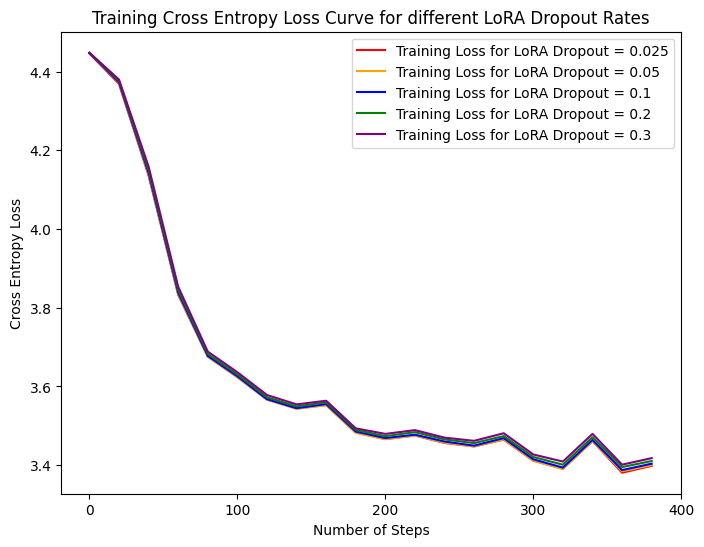

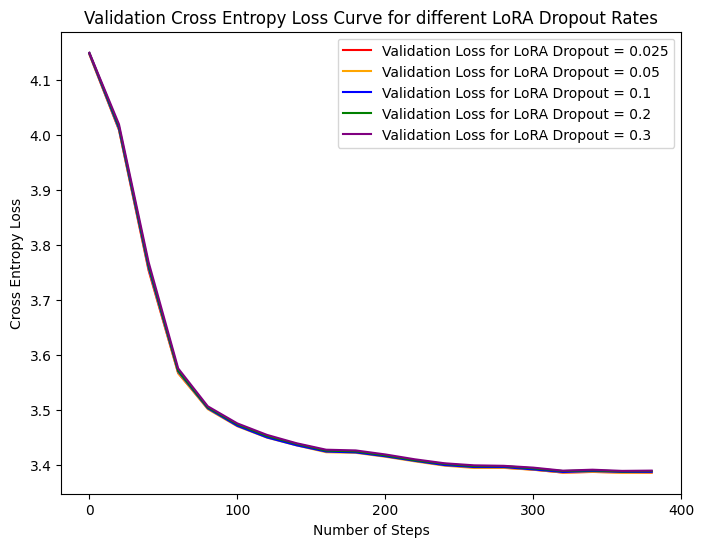

In [13]:
colors = ["red", "orange", "blue", "green", "purple"]

#Training Loss
plt.figure(figsize=(8, 6))
for i in range(len(hyperparams)):
    plt.plot(training_losses[hyperparams[i]], label=f"Training Loss for LoRA Dropout = {hyperparams[i]}", color=colors[i])

plt.xticks([0, 5, 10, 15, 20], [0, 100, 200, 300, 400])
plt.xlabel("Number of Steps")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Cross Entropy Loss Curve for different LoRA Dropout Rates")
plt.legend()
plt.show()


#Validation Loss
plt.figure(figsize=(8, 6))
for i in range(len(hyperparams)):
    plt.plot(validation_losses[hyperparams[i]], label=f"Validation Loss for LoRA Dropout = {hyperparams[i]}", color=colors[i])

plt.xticks([0, 5, 10, 15, 20], [0, 100, 200, 300, 400])
plt.xlabel("Number of Steps")
plt.ylabel("Cross Entropy Loss")
plt.title("Validation Cross Entropy Loss Curve for different LoRA Dropout Rates")
plt.legend()
plt.show()